<a href="https://colab.research.google.com/github/tewed/projects/blob/main/AB%20Testing%20Digital%20Marketing/A_B_Testing_2_Groups.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset source:
https://www.kaggle.com/datasets/amirmotefaker/ab-testing-dataset

The dataset contains information on an ad campaign run by an ecommerce company over a 1 month period.  

The data contains the following information:

* **Campaign Name:** The name of the campaign
* **Date:** Date of the record
* **Spend:** Amount spent on the campaign in dollars
* **Nr of Impressions:** Number of impressions the ad crossed through the campaign
* **Reach:** The number of unique impressions received in the ad
* **Nr of Website Clicks:** Number of website clicks received through the ads
* **Nr of Searches:** Number of users who performed searches on the website
* **Nr of View Content:** Number of users who viewed content and products on the website
* **Nr of Add to Cart:** Number of users who added products to the cart
* **Nr of Purchase:** Number of purchases

Two campaigns were performed by the company:

* Control Campaign
* Test Campaign


We want to test whether running the **test campaign** had any impact on the **Click-through rate** or **Conversion rate**, both of which are expressed as percentages

In [ ]:
# import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import mannwhitneyu
from statsmodels.stats.power import tt_ind_solve_power

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})


In [ ]:
# Mount the google drive, to allow import of the dataset
# from google.colab import drive
# drive.mount('/content/drive')

#   **1. Import Data**

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/Data/A B Testing - 2 Groups/test_group.csv'
                        ,sep=';'
                        ,date_format='%d.%m.%Y'
                        ,parse_dates = ['Date']
)
# confirm it imported correctly
df_test.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,2019-08-01,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2019-08-02,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,2019-08-03,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,2019-08-04,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,2019-08-05,2297,114295,95138,5863,2106,858,956,768


In [ ]:
df_control = pd.read_csv('/content/drive/MyDrive/Data/A B Testing - 2 Groups/control_group.csv'
                        ,sep=';'
                        ,date_format='%d.%m.%Y'
                        ,parse_dates = ['Date']
)
# confirm it imported correctly
df_control.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,2019-08-01,2280,"82,702.00","56,930.00","7,016.00","2,290.00","2,159.00","1,819.00",618.00
1,Control Campaign,2019-08-02,1757,"121,040.00","102,513.00","8,110.00","2,033.00","1,841.00","1,219.00",511.00
2,Control Campaign,2019-08-03,2343,"131,711.00","110,862.00","6,508.00","1,737.00","1,549.00","1,134.00",372.00
3,Control Campaign,2019-08-04,1940,"72,878.00","61,235.00","3,065.00","1,042.00",982.00,"1,183.00",340.00
4,Control Campaign,2019-08-05,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# df_test.dtypes
df_control.dtypes

,0
Campaign Name,object
Date,datetime64[ns]
Spend [USD],int64
# of Impressions,float64
Reach,float64
# of Website Clicks,float64
# of Searches,float64
# of View Content,float64
# of Add to Cart,float64
# of Purchase,float64


First, some **data quality checks** need to be conducted.  As part of this, some Exploratory data analysis will also be conducted.

  I can already see, from the dataset header, that there is missing data in the control campaign for 2019-08-05, this leads me to believe there might be other days that also have a problem.
  This was verified when looking at the source CSV file, that had 0 for all values noted.  

In [ ]:
# How many missing values are present in each dataset?
df_control.isna().sum()

,0
Campaign Name,0
Date,0
Spend [USD],0
# of Impressions,1
Reach,1
# of Website Clicks,1
# of Searches,1
# of View Content,1
# of Add to Cart,1
# of Purchase,1


In [ ]:
df_test.isna().sum()

,0
Campaign Name,0
Date,0
Spend [USD],0
# of Impressions,0
Reach,0
# of Website Clicks,0
# of Searches,0
# of View Content,0
# of Add to Cart,0
# of Purchase,0


There is only one record containing missing values - the 5th in the control group, so this would need to be considered when running any comparisons, as we would want to consider the same time periods for all of them.  
The missing values appear to be all related to a same incident (all the values are missing which could be caused by a data capturing failure).  
I will investigate more to see the distribution of the data

In [ ]:
df_control.describe(percentiles=[0.05,0.07,0.2, 0.25,0.75,0.8,0.95]).transpose()

,count,mean,min,5%,7%,20%,25%,50%,75%,80%,95%,max,std
Date,30,2019-08-15 12:00:00,2019-08-01 00:00:00,2019-08-02 10:48:00,2019-08-03 00:43:12,2019-08-06 19:12:00,2019-08-08 06:00:00,2019-08-15 12:00:00,2019-08-22 18:00:00,2019-08-24 04:48:00,2019-08-28 13:12:00,2019-08-30 00:00:00,NaN
Spend [USD],30.00,"2,288.43","1,757.00","1,817.40","1,836.20","1,898.40","1,945.50","2,299.50","2,532.00","2,611.80","2,882.30","3,083.00",367.33
# of Impressions,29.00,"109,559.76","71,274.00","72,660.20","72,863.48","87,702.20","92,029.00","113,430.00","121,332.00","126,890.20","141,935.40","145,248.00","21,688.92"
Reach,29.00,"88,844.93","42,859.00","53,964.20","56,732.28","67,015.20","74,192.00","91,579.00","102,479.00","104,115.00","122,977.20","127,852.00","21,832.35"
# of Website Clicks,29.00,"5,320.79","2,277.00","2,602.80","2,637.52","3,899.20","4,085.00","5,224.00","6,628.00","6,912.20","8,120.20","8,137.00","1,757.37"
# of Searches,29.00,"2,221.31","1,001.00","1,096.80","1,173.52","1,393.40","1,615.00","2,390.00","2,711.00","2,866.60","3,370.20","4,891.00",866.09
# of View Content,29.00,"1,943.79",848.00,991.20,"1,004.08","1,149.00","1,249.00","1,984.00","2,421.00","2,490.00","3,144.60","4,219.00",777.55
# of Add to Cart,29.00,"1,300.00",442.00,700.60,778.44,898.00,930.00,"1,339.00","1,641.00","1,700.60","1,859.80","1,913.00",407.46
# of Purchase,29.00,522.79,222.00,246.20,250.68,355.60,372.00,501.00,670.00,746.00,791.60,800.00,185.03


In [ ]:
df_test.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
Date,30,2019-08-15 12:00:00,2019-08-01 00:00:00,2019-08-08 06:00:00,2019-08-15 12:00:00,2019-08-22 18:00:00,2019-08-30 00:00:00,NaN
Spend [USD],30.00,"2,563.07","1,968.00","2,324.50","2,584.00","2,836.25","3,112.00",348.69
# of Impressions,30.00,"74,584.80","22,521.00","47,541.25","68,853.50","99,500.00","133,771.00","32,121.38"
Reach,30.00,"53,491.57","10,598.00","31,516.25","44,219.50","78,778.75","109,834.00","28,795.78"
# of Website Clicks,30.00,"6,032.33","3,038.00","4,407.00","6,242.50","7,604.75","8,264.00","1,708.57"
# of Searches,30.00,"2,418.97","1,854.00","2,043.00","2,395.50","2,801.25","2,978.00",388.74
# of View Content,30.00,"1,858.00",858.00,"1,320.00","1,881.00","2,412.00","2,801.00",597.65
# of Add to Cart,30.00,881.53,278.00,582.50,974.00,"1,148.50","1,391.00",347.58
# of Purchase,30.00,521.23,238.00,298.00,500.00,701.00,890.00,211.05




---





# **2. Data Preprocessing**

##    **2.1 Treating missing values**

I would need to treat the control data by imputing the missing values in the control campaign.  
Since we have campaign spend values, I will see if there is another day with similar spend.  
The spend on the 5th was 1835, which is slightly below the 7th percentile of spend.  
Considering that the spend might be related to the day of the week,
         I want to see if any of the other days that are on the same weekday, has similar spend

In [ ]:
# Extract all days that are the same day of the week as the 5h
df_control[df_control['Date'].dt.dayofweek == 0][['Date','Spend [USD]']]

,Date,Spend [USD]
4,2019-08-05,1835
11,2019-08-12,2319
18,2019-08-19,2596
25,2019-08-26,2233


The days examined, all had spend higher than the median of the spend on the control campaign, whereas the 5th had spend lower than the 7th percentile.  
Looking at the percentile distribution, the other values increase with an increase in spend, thus I would want to impute the values with similar values:  

*   I will impute the values with all the other 7th percentile values, this aims to keep the relationship between spend and the other factors



In [ ]:
# define values to impute with
impute_values = {'# of Impressions': 72863
          ,'Reach': 56732
          ,'# of Website Clicks': 2637
          ,'# of Searches': 1173
          ,'# of View Content':1004
          ,'# of Add to Cart': 778
          ,'# of Purchase':    250
          }
df_control.fillna(value=impute_values, inplace = True)
df_control.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,2019-08-01,2280,"82,702.00","56,930.00","7,016.00","2,290.00","2,159.00","1,819.00",618.00
1,Control Campaign,2019-08-02,1757,"121,040.00","102,513.00","8,110.00","2,033.00","1,841.00","1,219.00",511.00
2,Control Campaign,2019-08-03,2343,"131,711.00","110,862.00","6,508.00","1,737.00","1,549.00","1,134.00",372.00
3,Control Campaign,2019-08-04,1940,"72,878.00","61,235.00","3,065.00","1,042.00",982.00,"1,183.00",340.00
4,Control Campaign,2019-08-05,1835,"72,863.00","56,732.00","2,637.00","1,173.00","1,004.00",778.00,250.00


##    **2.2 Outliers**

I would like to invesstigate whether outlying values exist in the 2 datasets, so they could also be treated prior to tests being conducted.  

First, graphically show the distribution of relevant variables using boxplots

In [ ]:
variables = ['Spend [USD]', '# of Impressions', 'Reach',
            '# of Website Clicks', '# of Searches', '# of View Content',
            '# of Add to Cart', '# of Purchase']
# define a helper function to plot boxplots
def plot_boxplots(data, grouptype, color):

    for i in range(3):

        fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(12,5))

        ax1 = sns.boxplot(data[variables[i*3]], ax=ax1, color=color)
        ax1.set_title('Boxplot of '+ str(variables[i*3]), fontsize=15)

        ax2 = sns.boxplot(data[variables[i*3+1]], ax=ax2, color=color)
        ax2.set_title('Boxplot of '+str(variables[i*3+1]), fontsize=15)

        if i < 2:
            ax3 = sns.boxplot(data[variables[i*3+2]], ax=ax3, color=color)
            ax3.set_title('Boxplot of '+str(variables[i*3+2]), fontsize=15)

        fig.suptitle(f"Boxplots of the {grouptype} Variables", fontsize=24)

        plt.tight_layout()


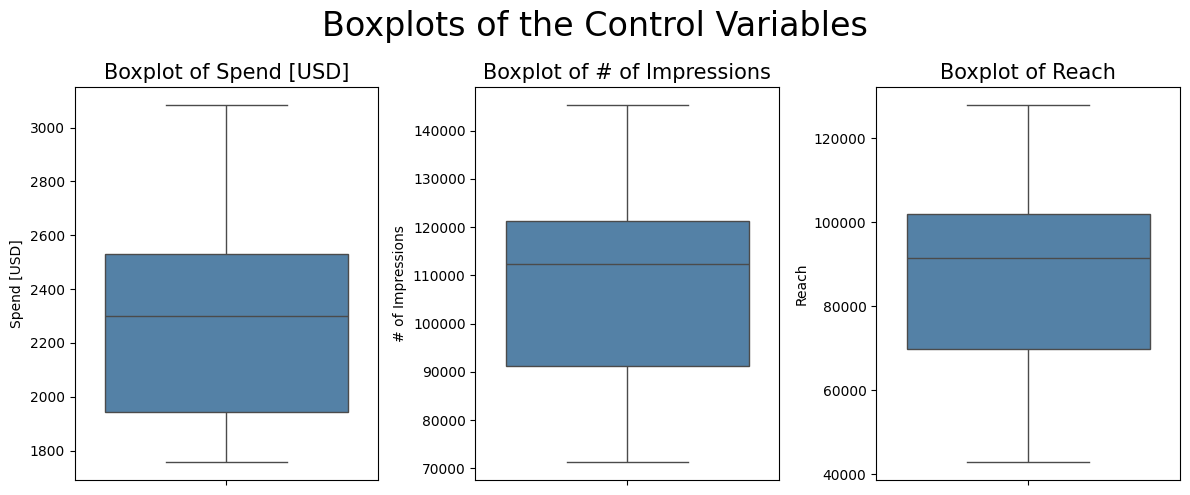

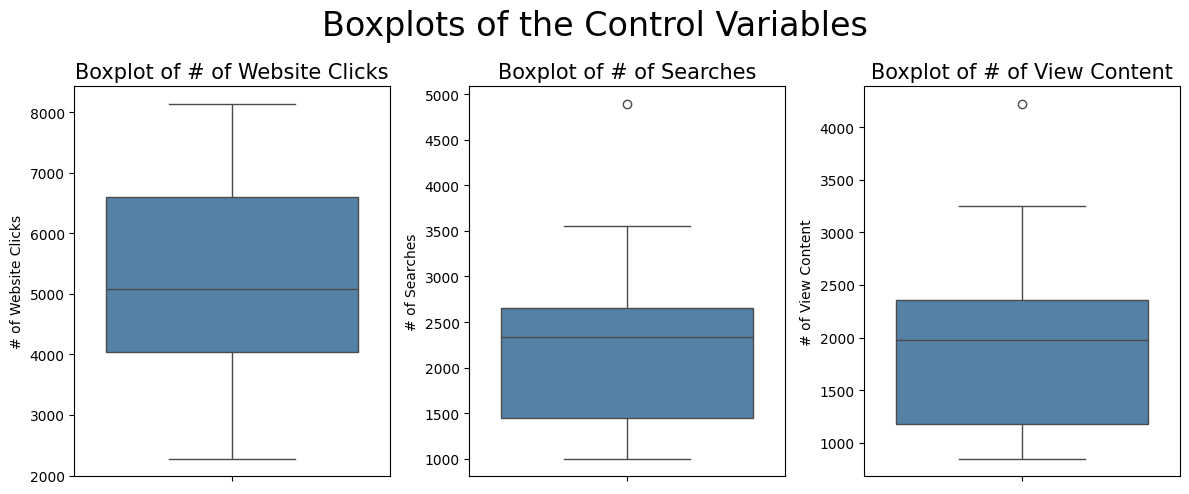

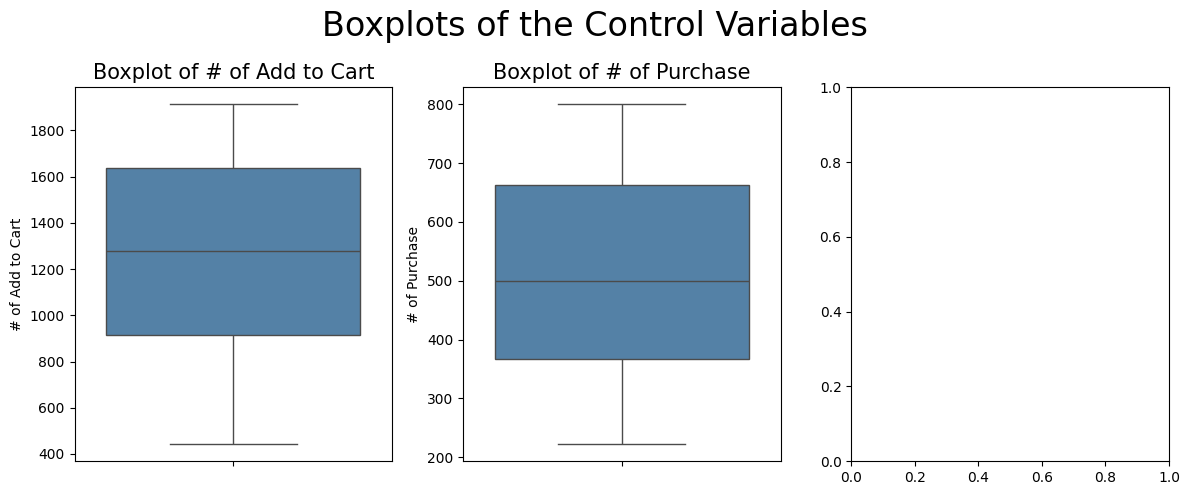

In [ ]:
plot_boxplots(df_control, 'Control', 'steelblue')

There appears to be some out;ying values in the Control data for :
*   Nr of Searches
*   Nr View Content



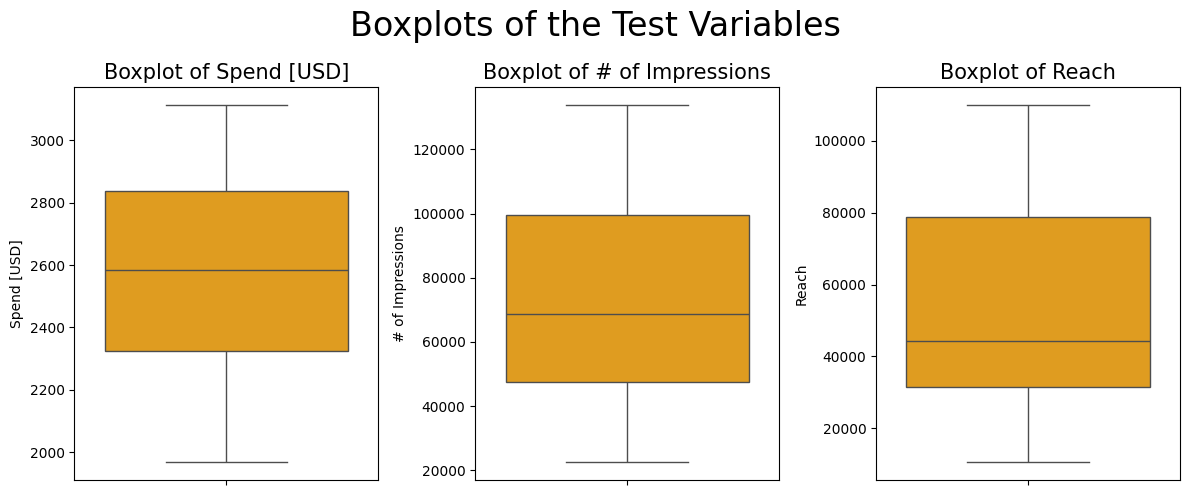

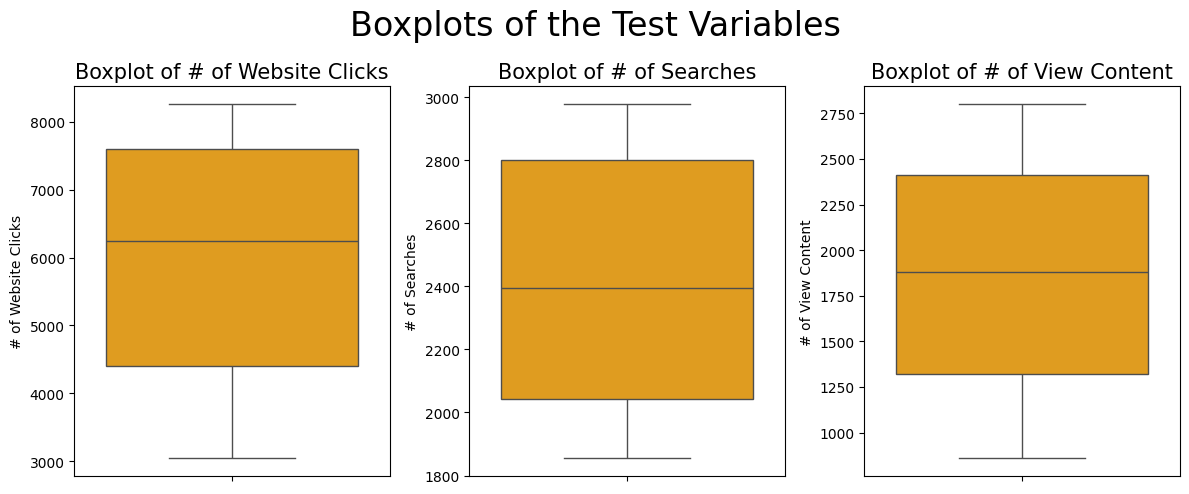

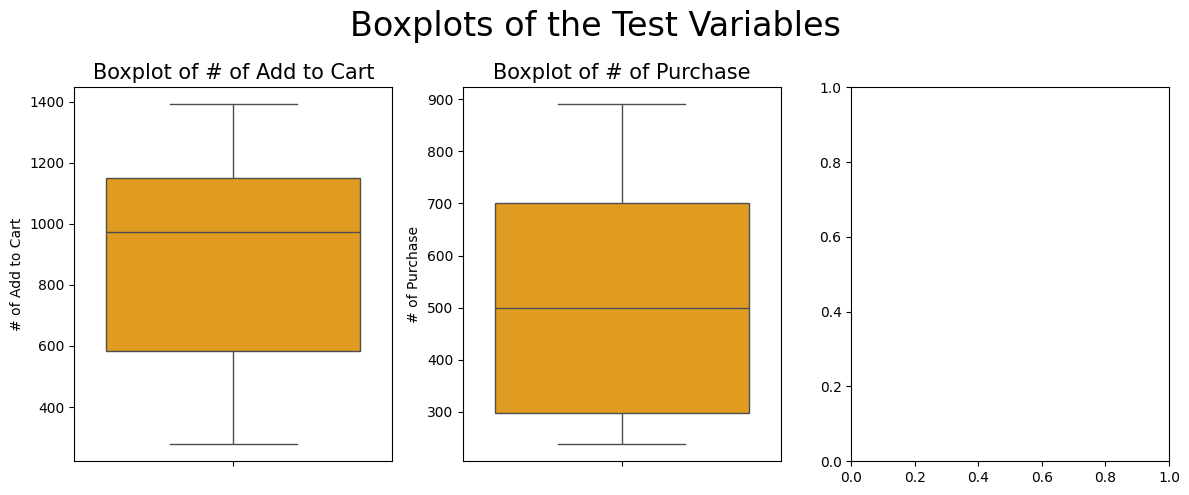

In [ ]:
plot_boxplots(df_test, 'Test', 'Orange')

The Test campaign does not appear to have any outlying values present.

Considering that the outlying values identified, will not be used in any definition of metrics, or be tested during this analysis, they will be ignored.

# **3. Metrics definition**

In [ ]:
# concatenate datasets into one DataFrame
df = pd.concat([df_control, df_test]
               ).reset_index()
df.head()

,index,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,0,Control Campaign,2019-08-01,2280,"82,702.00","56,930.00","7,016.00","2,290.00","2,159.00","1,819.00",618.00
1,1,Control Campaign,2019-08-02,1757,"121,040.00","102,513.00","8,110.00","2,033.00","1,841.00","1,219.00",511.00
2,2,Control Campaign,2019-08-03,2343,"131,711.00","110,862.00","6,508.00","1,737.00","1,549.00","1,134.00",372.00
3,3,Control Campaign,2019-08-04,1940,"72,878.00","61,235.00","3,065.00","1,042.00",982.00,"1,183.00",340.00
4,4,Control Campaign,2019-08-05,1835,"72,863.00","56,732.00","2,637.00","1,173.00","1,004.00",778.00,250.00


**Since our goal is to track Click-through rate and Conversion rate, these columns are added.**



*   Click-through rate is defined as the number of impressions that resulted in a click.  
Thus: *Total number of clicks divided by the total number of impressions*
*   Conversion rate is defined as the number of times a purchase is made for each vistor to the website.  
Thus: *Total number of conversions divided by the Total # of Website Clicks*

In [ ]:
# Add columns needed for the analysis
# add click through rate
df['CTR'] = df['# of Website Clicks'] / df['# of Impressions']
# add conversion rate
df['CR'] = df['# of Purchase'] / df['# of Website Clicks']
df.head()

,index,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase,CTR,CR
0,0,Control Campaign,2019-08-01,2280,"82,702.00","56,930.00","7,016.00","2,290.00","2,159.00","1,819.00",618.00,0.08,0.09
1,1,Control Campaign,2019-08-02,1757,"121,040.00","102,513.00","8,110.00","2,033.00","1,841.00","1,219.00",511.00,0.07,0.06
2,2,Control Campaign,2019-08-03,2343,"131,711.00","110,862.00","6,508.00","1,737.00","1,549.00","1,134.00",372.00,0.05,0.06
3,3,Control Campaign,2019-08-04,1940,"72,878.00","61,235.00","3,065.00","1,042.00",982.00,"1,183.00",340.00,0.04,0.11
4,4,Control Campaign,2019-08-05,1835,"72,863.00","56,732.00","2,637.00","1,173.00","1,004.00",778.00,250.00,0.04,0.09




---



# **4. Variable exploration**

In [ ]:
# define a helper function to plot the data
def plot_cols(data, col):
  df_reset = data.reset_index()
  fig, ax= plt.subplots(ncols=1, figsize=(8,4))

  ax = sns.lineplot(x='Date', y=col,
             data = df_reset, hue='Campaign Name',)

  ax.set_ylim([0, None])
  ax.set_xticklabels(ax.get_xticklabels(), size=7)
  ax.set_xticks(df['Date'].dt.date.unique().astype("datetime64")
                , df['Date'].dt.date.unique().astype("datetime64")
                , rotation=90, ha='right')

  # add the average spend per campaign type
  ax.axhline(y=df[df['Campaign Name'] == 'Test Campaign'][col].mean()   , color='orange', ls='--'   , label='Test Avg ' + col)
  ax.axhline(y=df[df['Campaign Name'] == 'Control Campaign'][col].mean(), color='steelblue', ls='--', label='Control Avg ' + col)

  ax.legend(fontsize=8, loc='lower left')
  ax.set_title(col + ' Comparison')

*Note: although ways exist to plot all the features at once by manipulating the axis objects and subplots, I kept it simple by plotting one feature at a time to allow for individual variable analysis*

<ipython-input-17-8a4d5974868a>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), size=7)


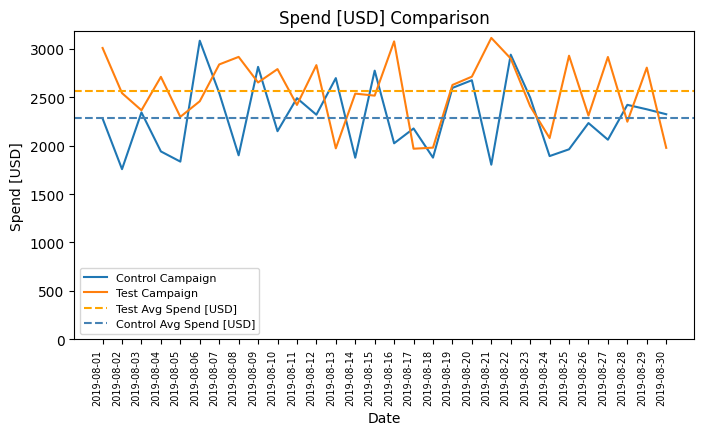

In [ ]:
plot_cols(df,'Spend [USD]' )

The average spend over the period is higher for the Test campaign compared to the Control.

<ipython-input-17-8a4d5974868a>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), size=7)


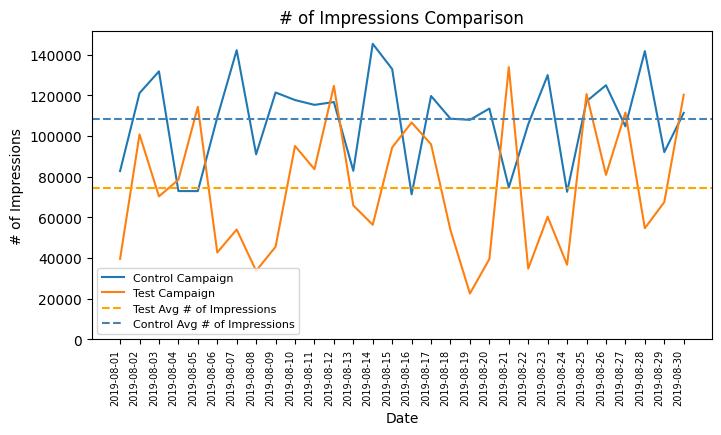

In [ ]:
plot_cols(df,'# of Impressions')

The average number of impressions for the control campaign is quite higher than the test campaign, even though the Test campaign had higher average spend over the period.

<ipython-input-17-8a4d5974868a>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), size=7)


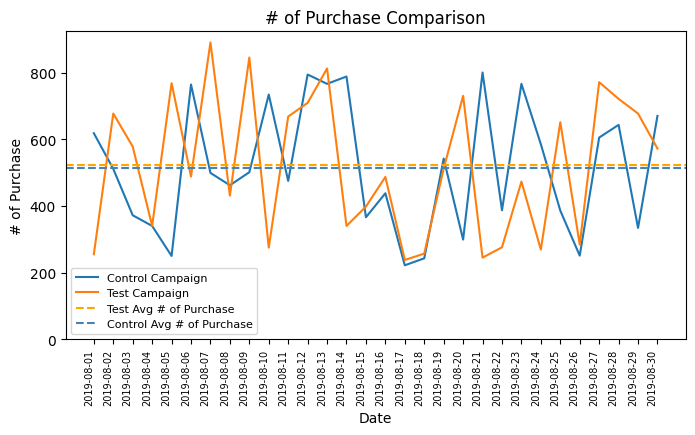

In [ ]:
plot_cols(df,'# of Purchase')

In [ ]:
# Calculate the % difference in the campaign purchases
round(100 - ( df[df['Campaign Name'] == 'Control Campaign']['# of Purchase'].mean() / df[df['Campaign Name'] == 'Test Campaign']['# of Purchase'].mean()  * 100),2)

1.45

The average number of purchases vary slightly between the groups, with the Test campaign having ~1.5% higher purchases than the Control campaign.

<ipython-input-17-8a4d5974868a>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), size=7)


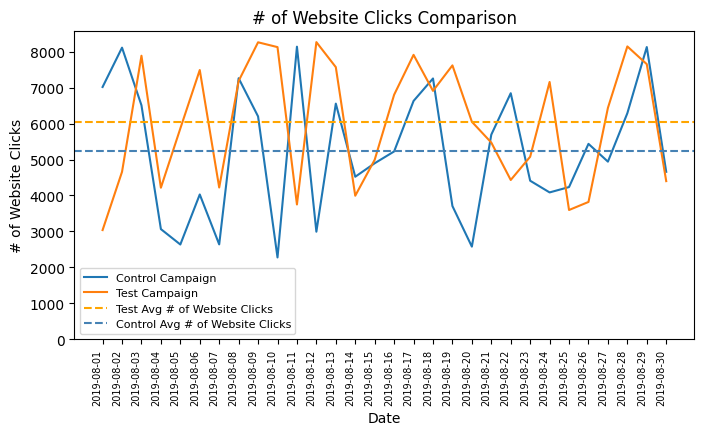

In [ ]:
plot_cols(df, '# of Website Clicks')

The Test campaign seemingly had a larger average number of clicks than the Control.

<ipython-input-17-8a4d5974868a>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), size=7)


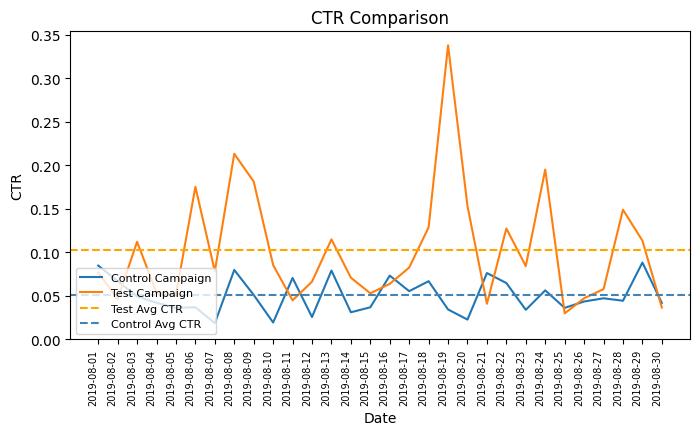

In [ ]:
plot_cols(df, 'CTR')

The test campaign had roughly  2 times the click through rate of the control, which could be attributed to the larger amount of average clicks overall.  
There is also two large spikes in the CTR for the Test campaign on the 6th and the 19th, which is not mirrored in the Control

<ipython-input-17-8a4d5974868a>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), size=7)


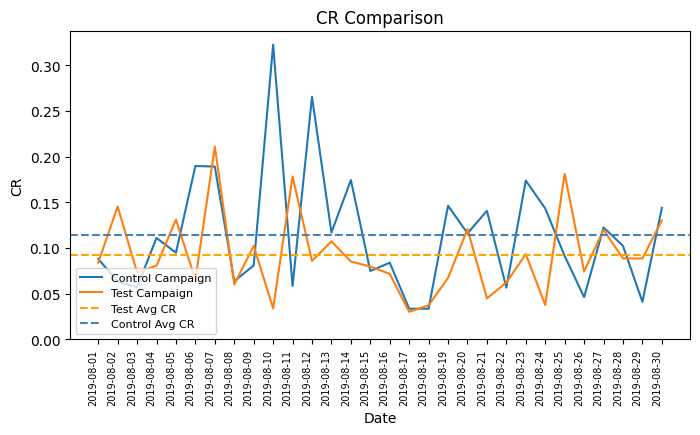

In [ ]:
plot_cols(df, 'CR')

The Test campaign had a slightly lower (~3%) conversion rate than the Control campaign.  
There are also large spikes on the 10th, 12th and the 23rd for the CR of the Control campaign that is not mirrored in the Test campaign.



---



# **5. Assumption Testing**

The t-test has the following assumptions that need to be met, for it to be considered appropriate:



*   The data are continuous: In this case the data IS continuous.
*   The sample data have been randomly sampled from a population: The assumption here is that the data was sampled randomly however it is not clear in the data specifications whether that was the case.
*   The distribution is approximately normal : This will be tested using the Shapiro-wilkes test
*   There is homogeneity of variance (i.e., the variability of the data in each group is similar): This will be tested using Levene's test for equal variance


Should the assumptions of the t-test not hold, a non-parametric test like the Mann-Whitney U test will be used.


## **5.1 Test for Normality**

### 5.1.1 Visual Examination

A visual inspection of the metrics, using a QQ-plot will be conducted first

A QQ-plot is used to visually compare one distribution with another, in this case - the metrics' distribution will be compared agains the theoretical normal distribution

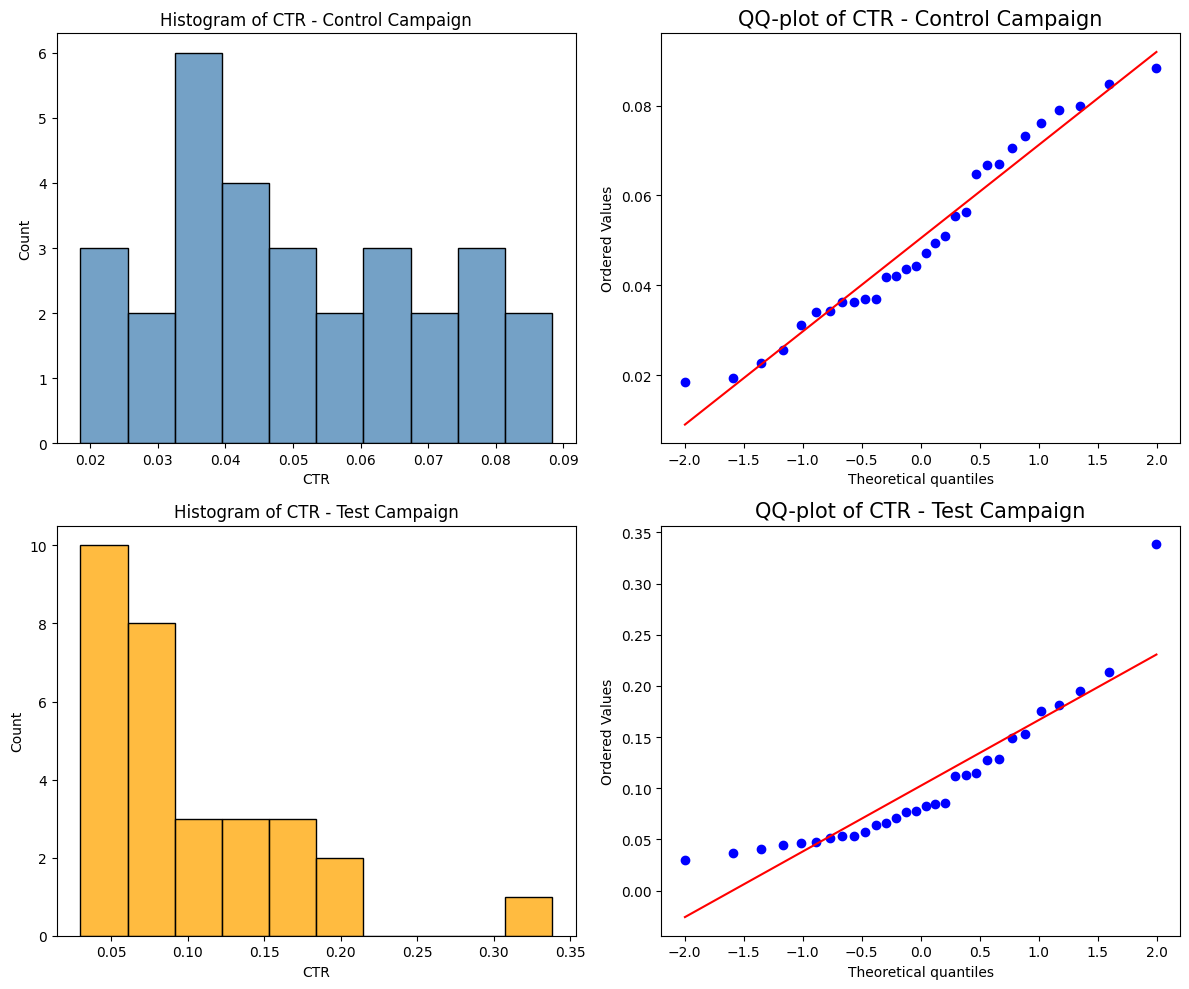

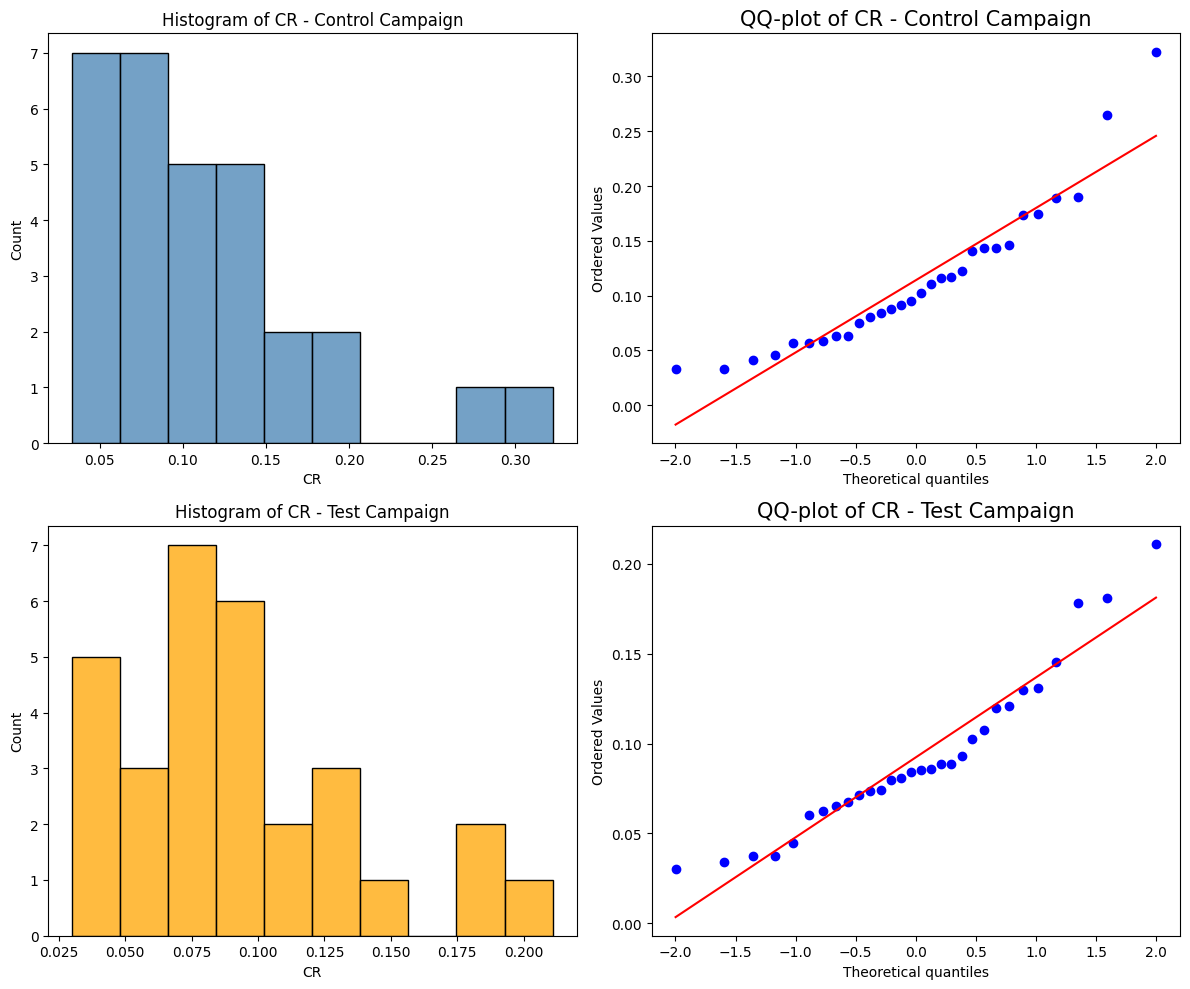

In [ ]:
metrics = ["CTR", "CR"]

for metric in metrics:
  fig, axes = plt.subplots(2,2, figsize=(12,10))
  # the amount of bins were chosen as being a third of the amount of days, to allow for multiple points to be presented into one bar
  sns.histplot(df[df['Campaign Name'] == 'Control Campaign'][metric], bins=10, color='steelblue', ax=axes[0][0])
  axes[0][0].set_title(f'Histogram of {metric} - Control Campaign')
  stats.probplot(df[df['Campaign Name'] == 'Control Campaign'][metric], dist='norm', plot=axes[0][1])
  axes[0][1].set_title(f"QQ-plot of {metric} - Control Campaign", fontsize=15)

  sns.histplot(df[df['Campaign Name'] == 'Test Campaign'][metric], bins=10, color='orange', ax=axes[1][0])
  axes[1][0].set_title(f'Histogram of {metric} - Test Campaign')
  stats.probplot(df[df['Campaign Name'] == 'Test Campaign'][metric], dist='norm', plot=axes[1][1])
  axes[1][1].set_title(f"QQ-plot of {metric} - Test Campaign", fontsize=15)

  plt.tight_layout()


From the figures above, it appears that there are slight deviations from normality for both metrics in both campaigns / groups. However, these deviations might be trivial.

Considering this, I will conduct a formal statistical test (Shapiro-Wilk test) to evaulate this

### 5.1.2 Shapiro-Wilk Test

The Shapiro-Wilk test is a test for normality of a dataset, that works well with small sample sizes.

The Null-hypothesis for this test, is that the population IS normally distributed, and the hypothesis is tested at a p-value of less than or equal to 0.05.

It is noted that with large sample sizes, the test might detect trivial deviations from normality, however, considering that this dataset only has 30 datapoints, the dataset is not considered large enough to have that effect.

In [ ]:
for metric in metrics:

  print("\nMetric Tested for Control Campaign: ",f"{metric}")
  test_stat, pvalue = shapiro(df[df['Campaign Name'] == 'Control Campaign'][metric])
  print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

  print("\nMetric Tested for Test Campaign: ",f"{metric}")
  test_stat, pvalue = shapiro(df[df['Campaign Name'] == 'Test Campaign'][metric])
  print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))


Metric Tested for Control Campaign:  CTR
Test Stat = 0.9512, p-value = 0.1817

Metric Tested for Test Campaign:  CTR
Test Stat = 0.8409, p-value = 0.0004

Metric Tested for Control Campaign:  CR
Test Stat = 0.8923, p-value = 0.0055

Metric Tested for Test Campaign:  CR
Test Stat = 0.9255, p-value = 0.0373


Looking at the p-values calculated, all but the Click-Through Rate (CTR) for the Control Campaign reject the null-hypothesis that the variables are normally distributed.

## 5.2 Test for Homogeniety of Variance

Although the normality test's showed that the distributions are NOT normally distributed across the board, and it violates the assumptions of the t-test, it was by chance that the normality test was conducted first.  

I would like to still test the homogeniety of variance even though I already know I will not be using a parametric test.

### 5.2.1 Levene's Test for Homogeniety of Variances

Levene's test for homogeniety of variances between two groups has a null hypothesis that says the variances are equal between the two groups.  
In this instance, a p-value (significance level) of less than 0.05 will indicate that the null hypothesis will be rejected and we can conclude that the variances are not equal.

In [ ]:
for metric in metrics:
  levene_test = stats.levene(df[df['Campaign Name'] == 'Control Campaign'][metric], df[df['Campaign Name'] == 'Test Campaign'][metric])

  print(f"\nLevene's Test for Homogeneity of Variances: {metric}")
  print(f"Statistic = {levene_test.statistic}, p-value = {levene_test.pvalue}")



Levene's Test for Homogeneity of Variances: CTR
Statistic = 10.135736964790748, p-value = 0.0023391735260805627

Levene's Test for Homogeneity of Variances: CR
Statistic = 2.867308049687358, p-value = 0.0957609350112682


Based on the above results, we can conclude that:



*   The difference in variances of the Click-Through Rate (CTR) is NOT statistically significant, and the null hypothesis cannot be rejected.
*   The difference in variances of the Conversion Rates (CR) ARE significant and you can reject the null hypothesis.

Based on this, the assumption of homegeniety of variances for all metrics are not met.


# **6. Hypothesis testing**

Based on the results from Section 5, that the metrics for the groups are NOT normally distributed, and they do not have homogeniety of variance for all of the groups, the t-test will not be a reliable test to use as it is generally considered to lead to inaccurate results.

Considering this, the main conclusions will be based on a non-parametric test, although the parametric t-test will ALSO be conducted to get a view of the results it generates.

The hypothesis that will be tested throughout is:

Null Hypothesis (H0):

*   The distribution of *metric* of the Control Campaign is equal to the distribution of *metric* of the Test Campaign.

Alternative Hypothesis (H1):
*   The distribution of *metric* of the Control Campaign is not equal to the distribution of *metric* of the Test Campaign


Where *metric* refers to the Conversion rate (CR) and the Click-through rate (CTR)

## 6.1 Non-Parametric test

The non-parametric test that will be conducted, will be the Mann-Whitney U test.

This test works well when data is not normally dictributed, since it compares ranks amongst the dsitributions, vs the actual means like the t-test does.

Again, we use a siginifance level of 0.05.

In [ ]:
for metric in metrics:
    print(f'\nMann-Whitney U test for: {metric}')
    print(stats.mannwhitneyu(df[df['Campaign Name'] == 'Control Campaign'][metric], df[df['Campaign Name'] == 'Test Campaign'][metric]))


Mann-Whitney U test for: CTR
MannwhitneyuResult(statistic=194.0, pvalue=0.0001584609391324261)

Mann-Whitney U test for: CR
MannwhitneyuResult(statistic=523.0, pvalue=0.2837780479456242)


Based on these results:



*   The p-value is less than 0.05, indicating that the difference in the Click-Through Rate (CTR) between the Control and Test Campaign is statistically significant and we **can reject** the null hypothesis and we can conclude that the distributions are not equal.
*   The p-value is greater than 0.05, indicating that the difference in the Conversion Rate (CR) IS statistically significant, therefore you **cannot reject the null hypothesis**, and you can conclude that the **distributions are equal**.



## 6.2 Parametric Test

As noted before, this test is done for interest sake to see if the conclusions wouldve changed.

It is also useful to retain this test for future, if this notebook is used as a "template" for future tests.

The hypotheses that are tested, are:

Null Hypothesis (H0).
* There is no significant difference between the mean of *metric* for the control group and the test group.

Alternative Hypothesis (H1).
* There is a significant difference between the mean of *metric* for the control group for and the test group.

A significance level of 0.05 will be used.

In [ ]:
for metric in metrics:

    print(f'\nT-test for: {metric}')
    t_stat, p_value = stats.ttest_ind(df[df['Campaign Name'] == 'Control Campaign'][metric], df[df['Campaign Name'] == 'Test Campaign'][metric])
    print(f"T-statistic: {t_stat}, P-value: {p_value}")


T-test for: CTR
T-statistic: -4.025375731258163, P-value: 0.00016706940158032904

T-test for: CR
T-statistic: 1.4797910561259293, P-value: 0.1443405363956074


Based on these results:


*   The p-value is less than 0.05, indicating that the difference in the Click-Through Rate (CTR) between the Control and Test Campaign is statistically significant and we **can reject** the null hypothesis.
*   The p-value is greater than 0.05, indicating that the difference in the Conversion Rate (CR) IS statistically significant, therefore you **cannot reject the null hypothesis**, and you can conclude that the **distributions are equal**.



## 6.3 Hypothesis Testing Conclusion

The parametric and non-parametric tests had the same conclusion, although if they did not - the non-parametric test would be used to conclude.

Based on the results obtained, and the Variable Exploration conducted, we can conclude the following

*   For Click-Through rate (CTR):  
The click through rate was shown to be higher on average for the Test campaign vs the Control campaign, and the hypothesis testing confirmed that these results were statistically significant, therefore we can conclude that the **Test campaign is more engaging**.

*   Conversion Rate (CR):  
The Test camapgin was shown to have a lower conversion rate on average vs the Control campaign, and the hypothesis testing showed that there was not a significant difference between the two groups, therefore the difference is more likely due to random chance vs the actual campaign.



# **7. Effect Size**

Effect size is a value that measures the **strength** of the relationship between two groups.  
Since we decided that the Mann-Whitney U test would be the appropriate test, a common effect size measure is the rank biserial correlation from U and from the sample size.

This measure indicates the **strength** and direction of the relationship between two groups.  



Interpretation:

**Range:**

The Rank-Biserial Correlation ranges from -1 to 1.
-1 indicates that all values in one group are smaller than all values in the other group.
1 indicates that all values in one group are larger than all values in the other group.
0 indicates that the distributions of the two groups overlap completely, meaning there is
no difference between the groups in terms of ranks.  
  
**Magnitude:**

Values near 1 or -1 suggest a strong effect, meaning there's a **significant difference** between the two groups.
Values near 0 suggest a weak or no effect.

The formula for the rank biserial correlation when using the Mann-Whitney U test, the Wendt formula, is:  

r = 1 – (2U)/ (n1 * n2)

Where U is the test statistic, and n1 and n1 relates to the sample sizes calculated.

In [ ]:
# calculate the U statistics to use in the calculation
ctr_t_stat, ctr_p_value = mannwhitneyu(df[df['Campaign Name'] == 'Control Campaign']['CTR'], df[df['Campaign Name'] == 'Test Campaign']['CTR'])
cr_t_stat, cr_p_value = mannwhitneyu(df[df['Campaign Name'] == 'Control Campaign']['CR'], df[df['Campaign Name'] == 'Test Campaign']['CR'])


In [ ]:
# Calculate the correlation

n1 = len(df[df['Campaign Name'] == 'Control Campaign'])
n2 = len(df[df['Campaign Name'] == 'Test Campaign'])
r_ctr = 1 - (2 * ctr_t_stat) / (n1 * n2)
r_cr = 1 - (2 * cr_t_stat) / (n1 * n2)

print(f"Effect size for CTR (rank-biserial correlation): {r_ctr:.3f}")
print(f"Effect size for CR (rank-biserial correlation): {r_cr:.3f}")

Effect size for CTR (rank-biserial correlation): 0.569
Effect size for CR (rank-biserial correlation): -0.162


**Interpretations**
1. Rank-Biserial Correlation for CTR: 0.56  

This value indicates a moderate positive effect size. A Rank-Biserial Correlation of 0.569 suggests that, on average, the ranks of CTR
(Click-Through Rate) in one group (likely the Test group) are moderately higher than in the other group (likely the Control group).
This means that the Test campaign is performing better than the Control campaign in terms of CTR.

2. Rank-Biserial Correlation for CR:  -0.162  

This value indicates a small negative effect size. A Rank-Biserial Correlation of -0.162 suggests that, on average, the ranks of
Conversion Rate in one group (likely the Control group) are slightly higher than in the other group (likely the Test group).
This means that the Control campaign is performing somewhat better than the Test campaign in terms of CR, but the difference is relatively small.

**Summary**:

CTR (0.569): The Test campaign shows a moderate improvement in CTR compared to the Control campaign.
CR (-0.162): The Control campaign shows a slight improvement in CR compared to the Test campaign, but the difference is not very strong.

# **8. Power Analysis and Sample Size**  

We did not have a chance to design the experiment, however it is still good practice to calculate wether the sample size (30) is large enough to detect a meaningful effect.  
  
We can use a power analysis to determine the required sample size for the experiment.

In [ ]:
# Calculate the effect size for CTR.
mean_control = df[df['Campaign Name'] == 'Control Campaign']['CTR'].mean()
mean_test = df[df['Campaign Name'] == 'Test Campaign']['CTR'].mean()

std_control = df[df['Campaign Name'] == 'Control Campaign']['CTR'].std()
std_test = df[df['Campaign Name'] == 'Test Campaign']['CTR'].std()

pooled_std = np.sqrt((std_control ** 2 + std_test ** 2) / 2)
cohen_d_ctr = (mean_control - mean_test) / pooled_std

# Power analysis for t-test
power_ctr = tt_ind_solve_power(effect_size=cohen_d_ctr, nobs1=n1, alpha=0.05,
                               power=None, ratio=1.0, alternative='two-sided')

print(f"Power of the CTR test: {power_ctr:.3f}")

Power of the CTR test: 0.977


In [ ]:
# Calculate the effect size for CTR.
mean_control = df[df['Campaign Name'] == 'Control Campaign']['CR'].mean()
mean_test = df[df['Campaign Name'] == 'Test Campaign']['CR'].mean()

std_control = df[df['Campaign Name'] == 'Control Campaign']['CR'].std()
std_test = df[df['Campaign Name'] == 'Test Campaign']['CR'].std()

pooled_std = np.sqrt((std_control ** 2 + std_test ** 2) / 2)
cohen_d_CR = (mean_control - mean_test) / pooled_std

# Power analysis for t-test
power_CR = tt_ind_solve_power(effect_size=cohen_d_CR, nobs1=n1, alpha=0.05,
                               power=None, ratio=1.0, alternative='two-sided')

print(f"Power of the CR test: {power_CR:.3f}")

Power of the CR test: 0.307
